#AI Powered Meal Planner
The AI-Powered Meal Planner is a personalized system that helps users generate daily meal plans based on their calorie requirements and nutritional preferences. It leverages unsupervised learning (clustering) to categorize foods into meaningful nutritional groups and uses a Hugging Face LLM to generate meal plans and recipes in a user-friendly format. The output includes recipes, grocery lists, and a macros donut chart to show nutritional balance.



In [3]:
import requests
import pandas as pd
import time

API_KEY = "NOAqiPFAbaa1z4heJnaPpDhjbCxopezbJn2MApdx"
SEARCH_URL = "https://api.nal.usda.gov/fdc/v1/foods/search"

nutrient_map = {
    "Energy": "calories",
    "Protein": "protein_g",
    "Carbohydrate, by difference": "carbs_g",
    "Total lipid (fat)": "fat_g",
    "Fiber, total dietary": "fiber_g",
    "Sugars, total": "sugar_g"
}

all_foods = []
page = 1
max_rows = 10000
collected = 0

while collected < max_rows:
    print(f"Fetching page {page}...")

    params = {
        "api_key": API_KEY,
        "query": "",  # leave blank for general foods
        "dataType": ["Survey (FNDDS)", "Branded"],
        "pageSize": 200,
        "pageNumber": page  # ✅ this is the missing key
    }

    resp = requests.get(SEARCH_URL, params=params)
    data = resp.json()
    foods = data.get("foods", [])

    if not foods:
        print("No more foods found.")
        break

    for f in foods:
        nutrients = {v: None for v in nutrient_map.values()}
        for n in f.get("foodNutrients", []):
            name = n.get("nutrientName")
            if name in nutrient_map:
                nutrients[nutrient_map[name]] = n.get("value")

        all_foods.append({
            "fdcId": f.get("fdcId"),
            "description": f.get("description"),
            "dataType": f.get("dataType"),
            **nutrients
        })

    collected += len(foods)
    page += 1
    time.sleep(0.25)  # small delay to avoid rate limit

    # Stop if total available foods are fetched
    total_hits = data.get("totalHits", 0)
    if collected >= total_hits:
        print("Reached total available foods.")
        break

df = pd.DataFrame(all_foods)
df.drop_duplicates(subset="fdcId", inplace=True)
df.to_csv("usda_foods_10k.csv", index=False)

print(f"✅ Collected {len(df)} unique foods with macros!")


Fetching page 1...
Fetching page 2...
Fetching page 3...
Fetching page 4...
Fetching page 5...
Fetching page 6...
Fetching page 7...
Fetching page 8...
Fetching page 9...
Fetching page 10...
Fetching page 11...
Fetching page 12...
Fetching page 13...
Fetching page 14...
Fetching page 15...
Fetching page 16...
Fetching page 17...
Fetching page 18...
Fetching page 19...
Fetching page 20...
Fetching page 21...
Fetching page 22...
Fetching page 23...
Fetching page 24...
Fetching page 25...
Fetching page 26...
Fetching page 27...
Fetching page 28...
Fetching page 29...
Fetching page 30...
Fetching page 31...
Fetching page 32...
Fetching page 33...
Fetching page 34...
Fetching page 35...
Fetching page 36...
Fetching page 37...
Fetching page 38...
Fetching page 39...
Fetching page 40...
Fetching page 41...
Fetching page 42...
Fetching page 43...
Fetching page 44...
Fetching page 45...
Fetching page 46...
Fetching page 47...
Fetching page 48...
Fetching page 49...
Fetching page 50...
✅ Collect

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# 1. Data Loading
# ----------------------------
df = pd.read_csv('usda_foods_10k.csv')

# Basic summary of the DataFrame
print(df.info())        # Overview of data types, non-null counts
print(df.describe())    # Statistical summary of numeric columns
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   fdcId        10000 non-null  int64  
 1   description  10000 non-null  object 
 2   dataType     10000 non-null  object 
 3   calories     9968 non-null   float64
 4   protein_g    9964 non-null   float64
 5   carbs_g      9938 non-null   float64
 6   fat_g        9960 non-null   float64
 7   fiber_g      8396 non-null   float64
 8   sugar_g      0 non-null      float64
dtypes: float64(6), int64(1), object(2)
memory usage: 703.3+ KB
None
              fdcId      calories    protein_g      carbs_g        fat_g  \
count  1.000000e+04   9968.000000  9964.000000  9938.000000  9960.000000   
mean   2.458498e+06    208.097010     6.810795    22.031502    10.592463   
std    3.995214e+05    229.670875     8.505979    38.608623    20.605913   
min    3.838440e+05      0.000000     0.000000     0.00000

In [10]:
# ----------------------------
# 2. Initial Exploration
# ----------------------------
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing values:\n", df.isna().sum())

Shape: (10000, 9)

Columns: ['fdcId', 'description', 'dataType', 'calories', 'protein_g', 'carbs_g', 'fat_g', 'fiber_g', 'sugar_g']

Missing values:
 fdcId              0
description        0
dataType           0
calories          32
protein_g         36
carbs_g           62
fat_g             40
fiber_g         1604
sugar_g        10000
dtype: int64


In [11]:
# ----------------------------
# 3. Handle missing values
# ----------------------------
df = df.drop(columns=["sugar_g"])

# Drop rows where description contains 'raw' (case-insensitive)
df.drop_duplicates(inplace=True)
df = df[~df['description'].str.contains("raw", case=False, na=False)]
df = df[~df['description'].str.contains("baby", case=False, na=False)]

# Strategy: Fill with median (robust to skewness)
median_cols = ['protein_g','carbs_g','fat_g','fiber_g']
for col in median_cols:
    df[col] = df[col].fillna(df[col].median())

# Only apply formula where calories are missing
mask = df["calories"].isna()

df.loc[mask, "calories"] = (
    4 * df.loc[mask, "protein_g"].fillna(0) +
    4 * df.loc[mask, "carbs_g"].fillna(0) +
    9 * df.loc[mask, "fat_g"].fillna(0)
)


In [12]:
print("Shape:", df.shape)

Shape: (9617, 8)


In [13]:
df.to_csv("original.csv", index=False)


In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
features = ['calories','protein_g','carbs_g','fat_g','fiber_g',]
X = df[features]

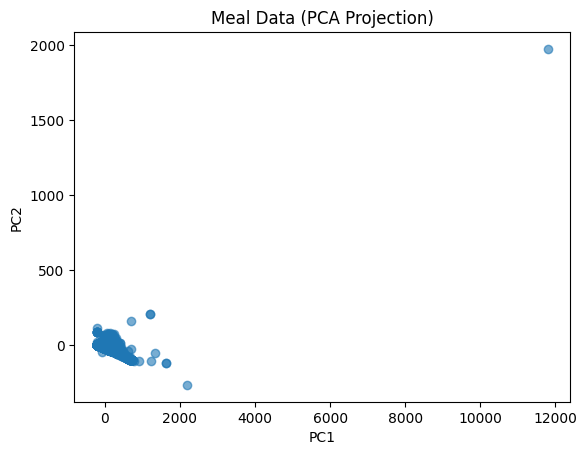

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Meal Data (PCA Projection)")
plt.show()


This image is a scatter plot titled "Meal Data (PCA Projection)" with axes labeled "PC1" (Principal Component 1) and "PC2" (Principal Component 2). The plot visualizes two-dimensional data points derived from a Principal Component Analysis (PCA) of a meal dataset. Most of the data points cluster tightly in the lower left of the plot, with both PC1 and PC2 values relatively small. There are two clear outlier points, each with much higher PC1 and PC2 values, indicating they have very different characteristics compared to the majority of the data.Check the outliers to see if they are errors or important, then decide if they should be removed or kept.

In [16]:
def remove_outliers_iqr(df, factor=1.5):
    df_clean = df.copy()
    num_cols = df_clean.select_dtypes(include=[np.number]).columns

    for col in num_cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]

    return df_clean

df_clean = remove_outliers_iqr(df, factor=1.5)


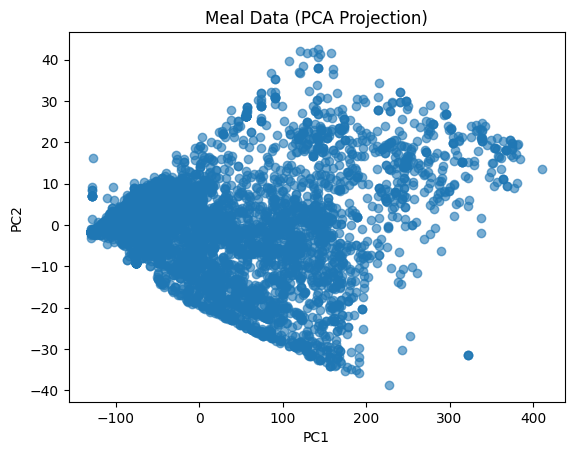

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = df_clean[features]
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Meal Data (PCA Projection)")
plt.show()


In [18]:
X.to_csv("meal_features_cleaned.csv", index=False)


In [19]:
X.head()

,calories,protein_g,carbs_g,fat_g,fiber_g
0,177.0,21.24,7.46,6.12,0.0
1,172.0,16.89,8.14,7.66,0.4
2,181.0,17.69,8.86,7.94,0.2
4,88.0,0.21,2.10,2.38,0.0
5,58.0,0.90,0.27,0.00,0.0
